Que funciones/estrategias vais a aplicar para decidir la nueva v y w en función de los parámetros medidos en cada nueva imagen/frame? Cuales serán dichos parámetros?

Rango de color de la bola, Tamaño de la bola en la imagen y posición.
Cuando detecta blob de tamaño mínimo y color gira en la dirección adecuada para centrarla y se acerca hasta que llega al tamaño necesario. Si la bola se mueve, gira en tal dirección hasta volverla a centrar. 
Dar vueltas sobre sí mismo si no ve nada

Primera aproximación: sin localización relativa, girando y línea recta
w positivo (rot izq) si bola a la izq del centro
w negativo al revés
aumentar area línea recta en función de la raíz cuadrada del área


Segunda aproximación: con localización relativa explícita
generar trayectoria utilizando ambas a la vez

readme, codigo, log

In [10]:
import numpy as np
import time
import cv2
import math

In [ ]:
def createDetector(minThreshold=10, maxThreshold=200, minArea=200, maxArea=10000, minCircularity=0.1):
    # TODO: CAMBIAR detector con los parámetros conseguidos en get_color_blobs.py
    # Setup default values for SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # These are just examples, tune your own if needed
    # Change thresholds
    params.minThreshold = minThreshold
    params.maxThreshold = maxThreshold

    # Filter by Area
    params.filterByArea = True
    params.minArea = minArea
    params.maxArea = maxArea

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = minCircularity

    # Filter by Color
    params.filterByColor = False
    # not directly color, but intensity on the channel input
    #params.blobColor = 0
    params.filterByConvexity = False
    params.filterByInertia = False
    
    # Create a detector with the parameters
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3 :
        detector = cv2.SimpleBlobDetector(params)
    else:
        detector = cv2.SimpleBlobDetector_create(params)
    return detector

# Baja la cesta
def catch(self):
    self.BP.set_motor_position(self.PORT_MOTOR_PINZA, self.PINZA_ABAJO)
    return True

# Va hacia atrás y comprueba si hay algo del color de la bola en el rango
# PROBLEMA SI CHOCARA HACIA ATRÁS, se puede plantear sensor de distancia hacia atrás
def checkBallCaught(self, colorRangeMin, colorRangeMax):

    # en funcion a posicion de camara
    self.setSpeed(-0.15, 0)
    time.sleep(0.5)
    self.setSpeed(0, 0)

    x, y, area = detectBall(self, detector, colorRangeMin, colorRangeMax)

    # if there is no ball, is not in the basket
    if area <= 0:
        return False
    
    # if the ball is higher than 20% of screen, is not in the basket
    if y > 0.2:
        return False
    
    # if the ball is not in the 'middle' of the screen, is not in the basket
    # suponiendo que la camara enfoca partes fuera de la cesta
    if x < 0.2 or x > 0.8:
        return False
    
    # if not, the ball is in the basket
    return True 
    
# Sube la cesta
def release(self):
    self.BP.set_motor_position(self.basket_motor_port, 0)
    return True


def takePhoto(self):
    # TODO: implement 
    # Captura una imagen y la devuelve
    img = self.camera.read()
    return img
    
# Devuelve la velocidad (v,w) necesaria para dar vueltas sobre sí mismo 
# hasta que encuentra una bola 
def calcSearchSpeed(self, w):
    # hace elipses por si la bola está lejos
    v = 0.2
    return v, w




def detectBall(self, detector, colorRangeMin=100, colorRangeMax=255):
     # TODO: esto está bien para hsv?
     
    img = self.takePhoto()
     
    mask=cv2.inRange(img, colorRangeMin, colorRangeMax)
    # apply the mask
    img = cv2.bitwise_and(img, img, mask = mask) # TODO: añadir erosión o difuminado? 
    keypoints = detector.detect(255-mask)
    
    # Take biggest blob
    x, y, area = 0, 0, 0
    for kp in keypoints:
        if kp.size > area:
            x = kp.x
            y = kp.y
            area = kp.size

    # posicion a la esquina superior izquierda
    return x, y, area 



def trackObject(self, minTargetSize, targetX, objectiveTargetSize,
                    colorRangeMin, colorRangeMax, v_base, w_base,
                    catch=True):
    finished = False
    ball_caught = False
    area = 0
    detection_tolerance = 0.1

    self.release() # Comprobamos que la cesta está arriba

    detector = createDetector()
    
    # clear log file
    self.log_file = open(self.log_filename, "w")
    self.log_file.close() 

    while not finished:
        
        targetPositionReached = False
        # 1. search the most promising blob
        x, y, area = self.detectBall(detector, colorRangeMin, colorRangeMax)         
        
        # Dar vueltas hasta encontrar un objeto
        while area < minTargetSize:
            search_v, search_w = self.calcSearchSpeed(w_base)             
            self.setSpeed(search_v, search_w)
            time.sleep(self.tracking_period)
            x, y, area = self.detectBall(detector, colorRangeMin, colorRangeMax)


        # Objeto encontrado, paramos y buscamos
        print("Objeto encontrado")
        self.setSpeed(0, 0)
        time.sleep(0.1)
        
        while not targetPositionReached or not ball_caught: 
            # 2. v y w para acercarse a la bola
            x, y, area = self.detectBall(detector, colorRangeMin, colorRangeMax)  
            if area < minTargetSize:
                print("Objeto perdido")
                break
            
            v, w = self.calcTrackSpeed(x, y, area, targetX, objectiveTargetSize, v_base, w_base)
            self.setSpeed(v, w)
            
            # 3. check la posición válida para coger la bola
            if (abs(x - targetX) <  detection_tolerance):
                
                print("Posición válida para coger la bola")
                
                if catch:     
                    self.catch()
                    
                    if not self.checkBallCaught():
                        print("Fallo al coger la bola")
                        self.release()
                    else:
                        print("Bola cogida")
                        targetPositionReached = True  
                        
                else: # Si no hace falta coger la bola
                    targetPositionReached = True
                    
            # Si no estamos en el target o se ha escapado la bola continuamos           
            time.sleep(self.tracking_period)

        if targetPositionReached:
            finished = True
            self.setSpeed(0, 0)
                
    return finished

In [26]:
# Devuelve la velocidad (v,w) necesaria para seguir la bola
# x: posición de la bola
# area: tamaño de la bola
# targetX: posición objetivo
# objectiveTargetSize: tamaño objetivo de la bola
# v, w: velocidad base
# Utiliza sigmoid para suavizar la velocidad en relación a la posición de la bola
def calcTrackSpeed(x, area, targetX, objectiveTargetSize, v, w):
    # Calcular error de posición
    error_x = targetX - x
    
    # Calcular error de tamaño
    error_size = np.sqrt(objectiveTargetSize) - np.sqrt(area)
    
    # Constantes para ajustar sensibilidad (cómo de lineal es la sigmoidal)
    kp_position = 1  # Factor proporcional para posición
    kp_size = 1      # Factor proporcional para tamaño
    
    # Función sigmoid para suavizar la respuesta 
    # k regula cómo de lineal es la sigmoid
    def sigmoid(x, k=1):
        return 1 / (1 + np.exp(-k * x))
    
    # Ajuste de velocidad lineal (v) basado en error de tamaño
    # Si la bola es más pequeña que el objetivo -> avanzar
    # Si la bola es más grande que el objetivo -> retroceder
    v_adjusted = kp_size * (v * sigmoid(error_size) - (v/2))
    
    # Ajuste de velocidad angular (w) basado en error de posición
    # Si la bola está a la derecha del objetivo -> girar izquierda
    # Si la bola está a la izquierda del objetivo -> girar derecha
    w_adjusted = kp_position * (w * sigmoid(error_x) - (w/2))
    
    print("v_adjusted: ", v_adjusted)
    print("w_adjusted: ", w_adjusted)
    
    return v_adjusted, w_adjusted

calcTrackSpeed(100, 100, 200, 300, 0.2, 0.5)

v_adjusted:  0.09986772237112818
w_adjusted:  0.25


(0.09986772237112818, 0.25)

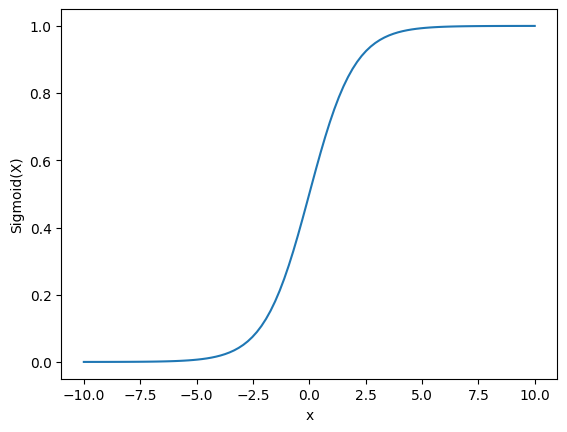

In [4]:
# Import matplotlib, numpy and math 
import matplotlib.pyplot as plt 
import numpy as np 
import math 
  
x = np.linspace(-10, 10, 100) 
z = 1/(1 + np.exp(-x)) 
  
plt.plot(x, z) 
plt.xlabel("x") 
plt.ylabel("Sigmoid(X)") 
  
plt.show() 